### This jupyter notebook is used to reproduce the results of the best models given in the paper

In [21]:
import pickle
from skmultilearn.adapt import brknn
from skmultilearn.adapt import MLkNN
from skmultilearn.problem_transform import br
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.neurofuzzy import MLARAM
import scipy
import sklearn.metrics
import argparse
import numpy
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble  import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import neighbors
from sklearn import ensemble
from sklearn import neural_network
from sklearn import linear_model
import gensim, sklearn
from collections import defaultdict
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
from xgboost import XGBClassifier
from sklearn.externals import joblib
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import VotingClassifier
import os
from string import punctuation
from gensim.parsing.preprocessing import STOPWORDS
import tensorflow as tf
import tensorflow_hub as hub
import re
from tqdm import tqdm
import pickle
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix,make_scorer, f1_score, accuracy_score, recall_score, precision_score, classification_report, precision_recall_fscore_support
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
ps = PorterStemmer()
import pandas as pd
import numpy as np
import json
from catboost import CatBoostClassifier
from scipy.sparse import vstack, hstack
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

#### This function is generating the classification report
1. input: ground_truth and predicted outputs
2. output: dataframe containing the results

In [8]:
# file used to write preserve the results of the classfier
# confusion matrix and precision recall fscore matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    return plt

#### This function is generating the classification report
1. input: ground_truth and predicted outputs
2. output: dataframe containing the results

In [9]:
##saving the classification report
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='macro'))
    avg.append(accuracy_score(y_true, y_pred, normalize=True))
    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support','accuracy']
    list_all=list(metrics_summary)
    list_all.append(cm.diagonal())
    class_report_df = pd.DataFrame(
        list_all,
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-2] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

### For Multilabel results production

In [23]:
###this is the metric used for calculating the scores 
def calculate_score(y_true, y_pred, normalize=True, sample_weight=None):

    acc_list = []
    accuracy = []
    precision = []
    recall = []
    f1_score = []

    for i in range(y_true.shape[0]):

        set_true = set( numpy.where(y_true[i])[0] )
        set_pred = set( numpy.where(y_pred[i])[0] )
        #print(set_true)
        #print(set_pred)
        
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float( len(set_true.union(set_pred)) )
            temp_acc = len(set_true.intersection(set_pred))/float( len(set_true.union(set_pred)) )
            if len(set_pred) == 0:
                temp_pre = 0
            else:
                temp_pre = len(set_true.intersection(set_pred))/float( len(set_pred) )
            temp_rec = len(set_true.intersection(set_pred))/float( len(set_true))
            temp_f1 = 2*(len(set_true.intersection(set_pred)))/float(len(set_pred) + len(set_true) )
        #print('tmp_a*: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
        accuracy.append(temp_acc)
        precision.append(temp_pre)
        recall.append(temp_rec)
        f1_score.append(temp_f1)
        
        
    mean_hamming=sklearn.metrics.hamming_loss(y_true, y_pred)
    mean_accuracy=numpy.mean(accuracy)
    mean_precision=numpy.mean(precision)
    mean_recall=numpy.mean(recall)
    mean_fscore=(2*mean_precision*mean_recall)/(mean_precision+mean_recall)
    return  mean_hamming,mean_accuracy,mean_precision,mean_recall,mean_fscore


In [24]:
def my_accuracy_score(y_train,y_train_pred):
    count=0
    for ele1,ele2 in zip(y_train,y_train_pred):
        if(list(ele1)==list(ele2)):
            count=count+1
    return count/y_train.shape[0]         

In [ ]:
path='XGB_gptpe_multilabel'
os.makedirs(path, exist_ok=True)
    
with open('Multilabel/all_preds_multilabel.pkl', 'rb') as f:
        y_total,y_total_preds=pickle.load(f)
        
ham,acc,pre,rec,f1=calculate_score(y_total,y_total_preds)
accuracy_test=my_accuracy_score(y_total,y_total_preds)
                   
for i in range(10):
    df_result=pandas_classification_report(y_total[:,i],y_total_preds[:,i])
    df_result.to_csv(path+'/report'+str(i)+'.csv')


f = open(path+'/final_report.txt', "w")

f.write("The hard metric score is :- " + str(accuracy_test)+"\n")
f.write("The accuracy is :- " + str(acc)+"\n")
f.write("The precision is :- " + str(pre)+"\n")
f.write("The recall is :- " + str(rec)+"\n")
f.write("The f1_score is :- " + str(f1)+"\n")
f.write("The hamming loss is :-" + str(ham)+"\n")
f.close()

### Results for binary classifier (all types)

In [19]:
def classification(confusion_name,report_name,pred_name_save):
    with open(pred_name_save, 'rb') as f:
            Classifier_Test_Y , y_pred=pickle.load(f)
    report = classification_report(Classifier_Test_Y , y_pred )
    cm=confusion_matrix(Classifier_Test_Y, y_pred)
    plt=plot_confusion_matrix(cm,normalize= True,target_names = ['counter','non_counter'],title = "Confusion Matrix")
    plt.savefig(confusion_name)
    print(report)
    df_result=pandas_classification_report(Classifier_Test_Y,y_pred)
    df_result.to_csv(report_name,  sep=',')
    

             precision    recall  f1-score   support

          0       0.56      0.40      0.47      1093
          1       0.62      0.75      0.68      1419

avg / total       0.59      0.60      0.59      2512

             precision    recall  f1-score   support

          0       0.71      0.38      0.49      1584
          1       0.53      0.82      0.64      1346

avg / total       0.63      0.58      0.56      2930

             precision    recall  f1-score   support

          0       0.47      0.45      0.46      1415
          1       0.71      0.72      0.71      2579

avg / total       0.62      0.63      0.62      3994

             precision    recall  f1-score   support

          0       0.70      0.67      0.68      4092
          1       0.76      0.77      0.77      5344

avg / total       0.73      0.73      0.73      9436

             precision    recall  f1-score   support

          0       0.62      0.63      0.63      4088
          1       0.71      0.70 

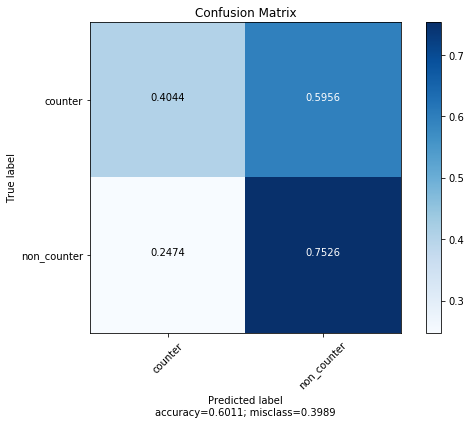

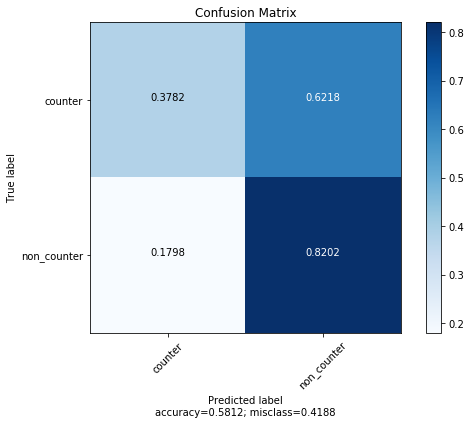

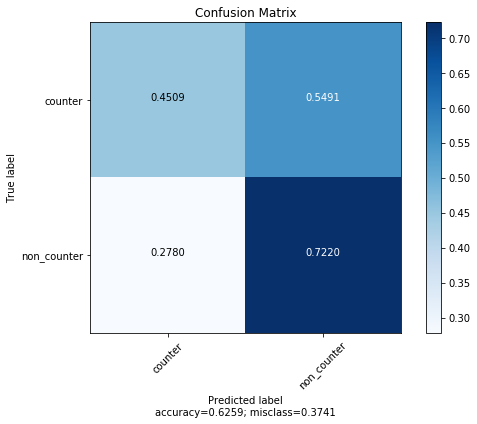

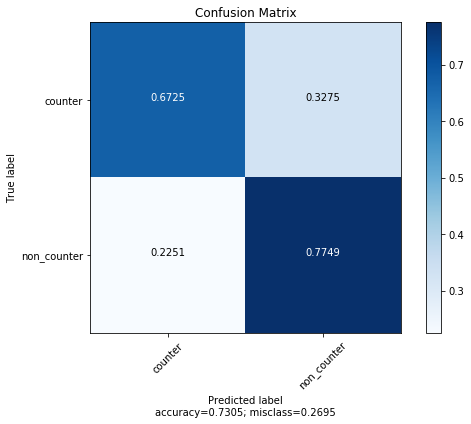

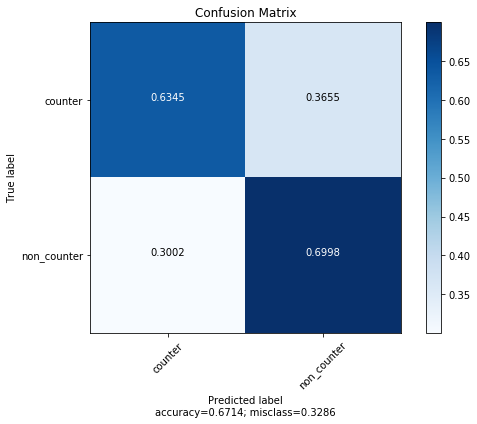

In [22]:
### prediction on black category trained using jew and lgbt  
classification(confusion_name='confusion_black_CB_gptp.png',report_name='confusion_black_CB_gptp.csv',pred_name_save='Counter_NonCounter/Classifier/black_all_save.pkl')

### prediction on lgbt category trained using jew and black  
classification(confusion_name='confusion_lgbt_MLP_gp.png',report_name='confusion_lgbt_MLP_gp.csv',pred_name_save='Counter_NonCounter/Classifier/lgbt_all_save.pkl')

### prediction on jew category trained using black and lgbt  
classification(confusion_name='confusion_jew_MLP_gp.png',report_name='confusion_jew_MLP_gp.csv',pred_name_save='Counter_NonCounter/Classifier/jew_all_save.pkl')

### prediction on total dataset trained using MLP and combination of all the three features 
classification(confusion_name='confusion_binary_MLP_gptpe.png',report_name='confusion_binary_MLP_gptpe.csv',pred_name_save='Counter_NonCounter/Classifier/all_preds_binary.pkl')

### prediction on total dataset trained using LSTM and random embeddings 
classification(confusion_name='confusion_lstm_random_embed.png',report_name='confusion_lstm_random_embed.csv',pred_name_save='Counter_NonCounter/Classifier/all_preds_lstm.pkl')
